In [1]:
from helper import *
import cv2 as cv
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel

In [2]:
SUBSET = '20k'
DATA_DIR = 'data/'
DATA_FILENAME = '1d_subset' + SUBSET

In [3]:
(X_train, X2_train, y_train), (X_test, X2_test, y_test) = \
    load2x_npz(DATA_DIR + DATA_FILENAME + '.npz')

((20000, 9216), dtype('uint8')) ((20000, 2304), dtype('uint8')) ((20000,), dtype('uint8'))
((10000, 9216), dtype('uint8')) ((10000, 2304), dtype('uint8')) ((10000,), dtype('uint8'))


In [4]:
def compute_feats(img):
    filtered = cv.cornerHarris(img, 5, 7, 0.03)
    # return np.array([filtered.mean(), filtered.var()])
    t = np.mean(filtered)
    u = np.median(filtered)
    return np.array([t, t-u, np.var(filtered)])

In [5]:
# Turn a <v> of size 9216 (96x96) into 1-D LDP feature vector of
# size 20 (two LDP histogram)
def vec_to_feat(v):
    feats1 = compute_feats(v[:9216].reshape(96, 96))
    feats2 = compute_feats(v[9216:].reshape(48, 48))
    return np.concatenate((feats1, feats2))

In [6]:
from math import ceil
def show(imgs):
    rows = ceil(len(imgs)/4)
    fig, ax = plt.subplots(rows, 4, figsize=(12,7))
    if rows == 1: ax = ax.reshape(1,-1)
    for i in range(rows * 4):
        col = i % 4
        row = i // 4
        ax[row][col].axis('off')
        if i >= len(imgs): 
            fig.delaxes(ax[row][col])
            continue
        ax[row][col].set_title(f'{i}')
        ax[row][col].imshow(imgs[i], cmap='gray')
    fig.tight_layout()

In [7]:
def show_filt(v):
    img = v.reshape(96,96)
    imgs = [img]
    imgs.append(cv.cornerHarris(img, 5, 7, 0.03))
    show(imgs)

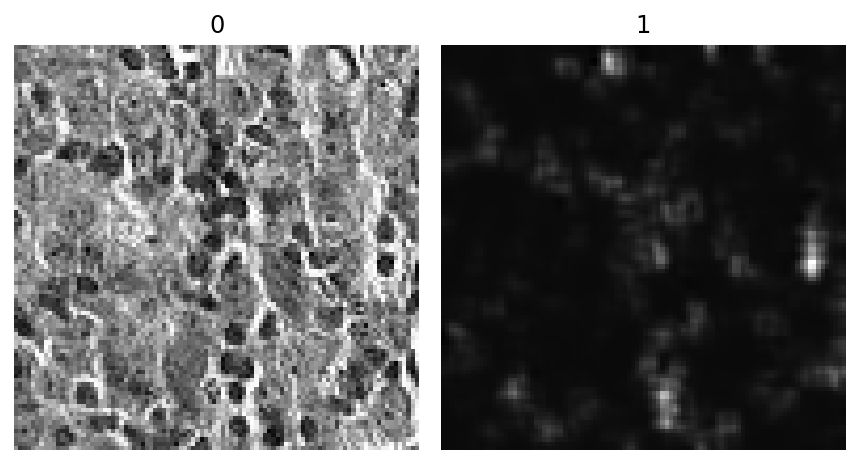

In [8]:
show_filt(X_train[0])
# assert False

In [9]:
Xf_train = np.apply_along_axis(delayed(vec_to_feat), 1, np.hstack((X_train, X2_train)))
Xf_train = np.concatenate(compute([x for x in Xf_train]))
Xf_train.shape, Xf_train.dtype

((20000, 6), dtype('float32'))

In [10]:
Xf_test = np.apply_along_axis(delayed(vec_to_feat), 1, np.hstack((X_test, X2_test)))
Xf_test = np.concatenate(compute([x for x in Xf_test]))
Xf_test.shape, Xf_test.dtype

((10000, 6), dtype('float32'))

In [11]:
SUBSET_FILENAME = 'harris_subset' + SUBSET
np.savez(DATA_DIR + SUBSET_FILENAME,
         X_train=Xf_train, y_train=y_train,
         X_test=Xf_test, y_test=y_test)

In [12]:
GBT(Xf_train, Xf_test, y_train, y_test)

n_est: Train, Test
400  : 82.2,  78.3
600  : 83.4,  78.3
800  : 84.5,  78.2
